# Data manipulation

## Data loading

In [4]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")

In [5]:
# Skip date
df1 = pd.read_csv('../input/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df2 = pd.read_csv('../input/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df1['Rating'] = df1['Rating'].astype(float)
df2['Rating'] = df2['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

print('Dataset 2 shape: {}'.format(df2.shape))
print('-Dataset examples-')
print(df2.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0
Dataset 2 shape: (26982302, 2)
-Dataset examples-
          Cust_Id  Rating
0           4500:     NaN
5000000    485565     2.0
10000000  1155911     2.0
15000000   121369     3.0
20000000  1277779     3.0
25000000   252632     5.0


In [6]:
df = df1
df = df1.append(df2)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (51040565, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0
25000000  1465002     3.0
30000000   961023     4.0
35000000  1372532     5.0
40000000   854274     5.0
45000000   116334     3.0
50000000   768483     3.0


## Data viewing

Let's give a first look on how the data spread:

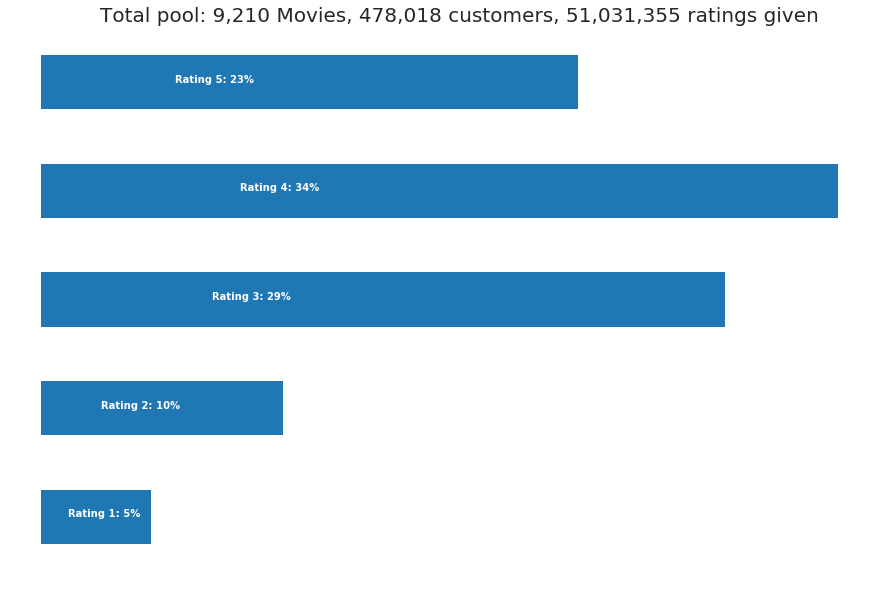

In [ ]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')



We can see that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. We can keep this in mind - low rating movies mean they are generally really bad

## Data cleaning

Movie ID is really a mess import! Looping through dataframe to add Movie ID column WILL make the Kernel run out of memory as it is too inefficient. I achieve my task by first creating a numpy array with correct length then add the whole array as column into the main dataframe! Let's see how it is done below:

In [ ]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

In [ ]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])


## Data slicing

The data set now is super huge. I have tried many different ways but can't get the Kernel running as intended without memory error. Therefore I tried to reduce the data volumn by improving the data quality below:

* Remove movie with too less reviews (they are relatively not popular)
* Remove customer who give too less reviews (they are relatively less active)

Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). This should help improve the statistical signifiance too.

Let's see how it is implemented:

In [ ]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Now let's trim down our data, whats the difference in data size?

In [ ]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Let's pivot the data set and put it into a giant matrix - we need it for our recommendation system:

In [ ]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

# Below is another way I used to sparse the dataframe...doesn't seem to work better

#Cust_Id_u = list(sorted(df['Cust_Id'].unique()))
#Movie_Id_u = list(sorted(df['Movie_Id'].unique()))
#data = df['Rating'].tolist()
#row = df['Cust_Id'].astype('category', categories=Cust_Id_u).cat.codes
#col = df['Movie_Id'].astype('category', categories=Movie_Id_u).cat.codes
#sparse_matrix = csr_matrix((data, (row, col)), shape=(len(Cust_Id_u), len(Movie_Id_u)))
#df_p = pd.DataFrame(sparse_matrix.todense(), index=Cust_Id_u, columns=Movie_Id_u)
#df_p = df_p.replace(0, np.NaN)


## Data mapping

Now we load the movie mapping file:

In [ ]:
df_title = pd.read_csv('../input/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

# Recommendation models

Well all data required is loaded and cleaned! Next let's get into the recommendation system.

## Recommend with Collaborative Filtering

Evalute performance of [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering), with just first 100K rows for faster process:

In [ ]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
data.split(n_folds=3)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

Below is what user 783514 liked in the past:

In [ ]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)


Let's predict which movies user 785314 would love to watch:

In [ ]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.train(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

## Recommend with Pearsons' R correlations

The way it works is we use Pearsons' R correlation to measure the linear correlation between review scores of all pairs of movies, then we provide the top 10 movies with highest correlations:

In [ ]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

A recommendation for you if you like 'What the #$*! Do We Know!?'

In [ ]:
recommend("What the #$*! Do We Know!?", 0)

X2: X-Men United:

In [ ]:
recommend("X2: X-Men United", 0)

# ct https://www.kaggle.com/laowingkin/netflix-movie-recommendation I was trying to replicate it by using a bigger dataset

**Recommend with Surprise!**

In [ ]:
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline

In [ ]:
from surprise import prediction_algorithms

In [ ]:
#i am not sure how to use this